In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from collections import defaultdict
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from scipy.sparse import lil_matrix
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unidecode
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
import random

# 📝 The purpose of this notebook is to :
- Clean up and standardize recipe ingredients
- Group together semantically similar ingredients (via embeddings)
- Reduce ingredient vocabulary to facilitate analysis
- Visualize clusters and save a cleaned CSV
- Provide an "ingredient -> clean form" dictionary

### 0️⃣ STEP 0 - Setup

In [2]:
df = pd.read_csv("data/clean_data/recipes_truncated.csv")
print(df.shape)
df.head()

(222705, 5)


,name_x,nutrition,n_steps,ingredients_y,minutes
0,arriba baked winter squash mexican style,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['winter squash', 'mexican seasoning', 'mixed ...",55
1,a bit different breakfast pizza,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['prepared pizza crust', 'sausage patty', 'egg...",30
2,all in the kitchen chili,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['ground beef', 'yellow onions', 'diced tomato...",130
3,alouette potatoes,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,"['spreadable cheese with garlic and herbs', 'n...",45
4,amish tomato ketchup for canning,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"['tomato juice', 'apple cider vinegar', 'sugar...",190


#### Parsing the ingredients_y column

In [3]:
# Check the type of the first value
print(f"\nOriginal type of ingredients_y: {type(df['ingredients_y'].iloc[0])}")
print(f"Example: {df['ingredients_y'].iloc[0]}")

# If it's a string (e.g., "['salt', 'pepper']"), convert to a Python list
if isinstance(df['ingredients_y'].iloc[0], str):
    print("Parsing ingredients_y from string to list...")
    df['ingredients_y'] = df['ingredients_y'].apply(ast.literal_eval)
    
# Verification after parsing
print(f"Type after parsing: {type(df['ingredients_y'].iloc[0])}")
print(f"Example after parsing: {df['ingredients_y'].iloc[0]}")


Original type of ingredients_y: <class 'str'>
Example: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']
Parsing ingredients_y from string to list...
Type after parsing: <class 'list'>
Example after parsing: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']


#### Building the vocabulary of ingredients

In [4]:
# Retrieve all ingredients and deduplicate within each recipe
all_ingredients = []

for ing_list in df['ingredients_y']:
    all_ingredients.extend(set(ing_list))  # removes duplicates within each recipe
    
# Create a list of unique ingredients and an index for each
unique_ingredients = sorted(set(all_ingredients))
ingredients_index = {ing: idx for idx, ing in enumerate(unique_ingredients)}
n = len(unique_ingredients)

print(f"Total number of recipes: {len(df)}")
print(f"Number of unique ingredients: {n}")

Total number of recipes: 222705
Number of unique ingredients: 14621


### 🧹 STEP 1 - Lexical cleaning of ingredients

In [5]:
def clean_ingredient(ing):
    ing = ing.lower()
    ing = unidecode.unidecode(ing)  # removes accents
    ing = re.sub(r'\([^)]*\)', '', ing)  # removes parentheses
    ing = re.sub(r'[^a-z\s]', '', ing)  # keeps letters and spaces
    ing = re.sub(r'\s+', ' ', ing).strip()  # removes multiple spaces
    return ing

df["ingredients_y"] = df["ingredients_y"].apply(
    lambda lst: [clean_ingredient(x) for x in lst]
)

print(f"Example after cleaning: {df['ingredients_y'].iloc[0]}")

Example after cleaning: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']


### 🧠 STEP 2 - Embeddings of unique ingredients

In [6]:
ingredients = list(set(x for lst in df["ingredients_y"] for x in lst))
print("Before reduction:", len(ingredients))

model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(ingredients, show_progress_bar=True)

Before reduction: 14540


Batches:   0%|          | 0/455 [00:00<?, ?it/s]

### 🔗 STEP 3 - Semantic clustering of ingredients

In [7]:
sim_matrix = cosine_similarity(embeddings)

# Hierarchical clustering based on cosine similarity
cluster = AgglomerativeClustering(
    n_clusters=None,
    metric="precomputed",
    linkage="average",
    distance_threshold=0.15  # similarity threshold (1 - 0.85)
)

labels = cluster.fit_predict(1 - sim_matrix)

### 🧭 STEP 4 - Creating the ingredient -> representative mapping

In [8]:
mapping_df = pd.DataFrame({"ingredient": ingredients, "cluster": labels})

# Choose the shortest representative for each cluster
representants = (
    mapping_df.groupby("cluster")["ingredient"]
    .apply(lambda g: min(g, key=len))
    .to_dict()
)

# Complete mapping dictionary
mapping = {row["ingredient"]: representants[row["cluster"]] for _, row in mapping_df.iterrows()}
print("After grouping:", len(set(mapping.values())))

# Apply mapping to the DataFrame
df["ingredients_reduced"] = df["ingredients_y"].apply(
    lambda lst: list(set(mapping.get(x, x) for x in lst))
)

After grouping: 9864


### 📊 STEP 5 - Reduction statistics

In [9]:
before = len(ingredients)
after = len(set(mapping.values()))

print(f"Reduction: {before} → {after} ({((1 - after/before)*100):.1f}%)")

# Display some clusters for inspection
for i in range(5):
    group = mapping_df[mapping_df["cluster"] == i]["ingredient"].tolist()
    print(f"Cluster {i}: {group[:10]}")

Reduction: 14540 → 9864 (32.2%)
Cluster 0: ['italian olive oil', 'lite olive oil', 'olive oil', 'light olive oil', 'pure olive oil']
Cluster 1: ['miniature candy canes', 'candy canes', 'candy cane']
Cluster 2: ['basic pizza dough', 'recipe pizza dough', 'pizza dough']
Cluster 3: ['lemonade', 'pink lemonade']
Cluster 4: ['espresso beans', 'espresso coffee', 'espresso']


### 🎨 STEP 6 - UMAP cluster visualization

c:\Users\edgar\anaconda3\envs\data_mining\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


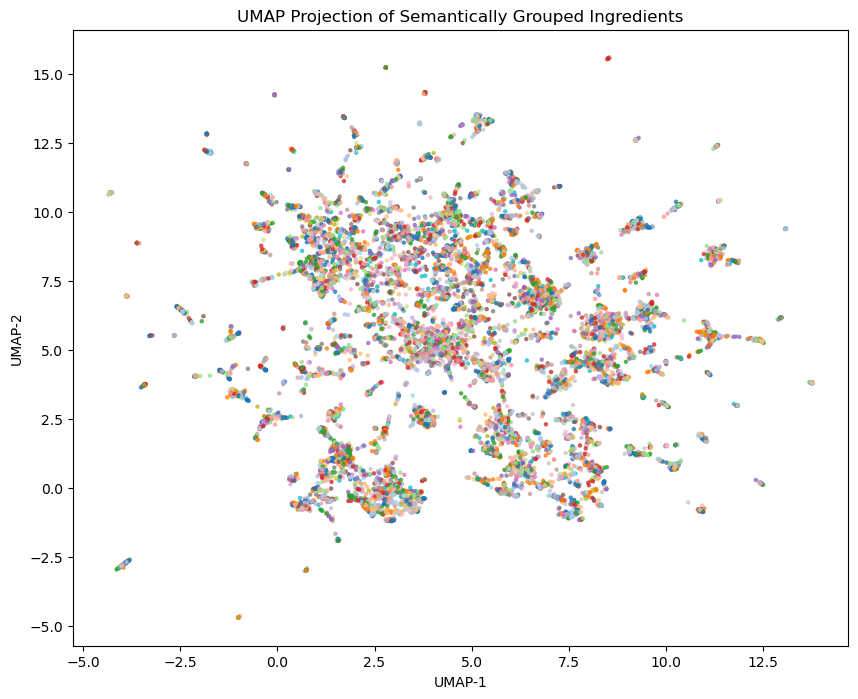

In [10]:
umap = UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)

emb_2d = umap.fit_transform(embeddings)
mapping_df["x"] = emb_2d[:, 0]
mapping_df["y"] = emb_2d[:, 1]

plt.figure(figsize=(10,8))
plt.scatter(
    mapping_df["x"],
    mapping_df["y"],
    c=mapping_df["cluster"],
    cmap="tab20",
    s=5,
    alpha=0.7
)
plt.title("UMAP Projection of Semantically Grouped Ingredients")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

### 📈 STEP 7 - Cluster size analysis

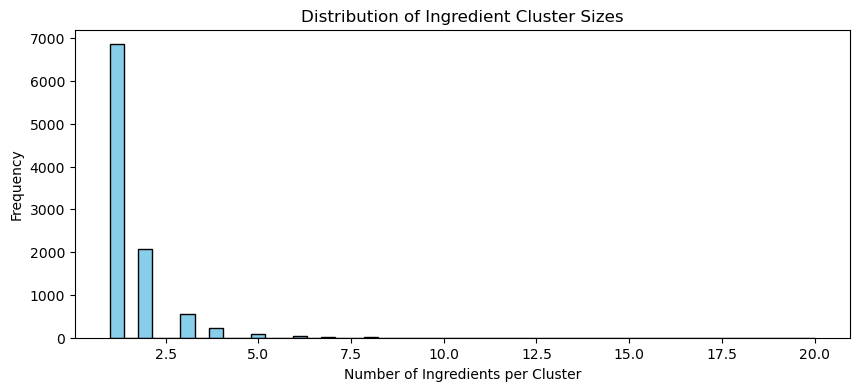

Total clusters: 9864
Average size: 1.47


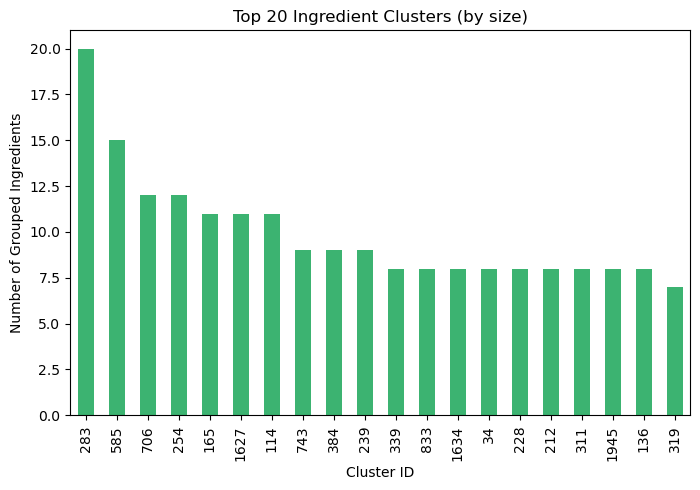

In [11]:
cluster_sizes = mapping_df["cluster"].value_counts()

plt.figure(figsize=(10,4))
plt.hist(cluster_sizes, bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Ingredient Cluster Sizes")
plt.xlabel("Number of Ingredients per Cluster")
plt.ylabel("Frequency")
plt.show()

print(f"Total clusters: {mapping_df['cluster'].nunique()}")
print(f"Average size: {cluster_sizes.mean():.2f}")

# Top 20 largest clusters
top_clusters = cluster_sizes.head(20)

plt.figure(figsize=(8,5))
top_clusters.plot(kind="bar", color="mediumseagreen")
plt.title("Top 20 Ingredient Clusters (by size)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Grouped Ingredients")
plt.show()

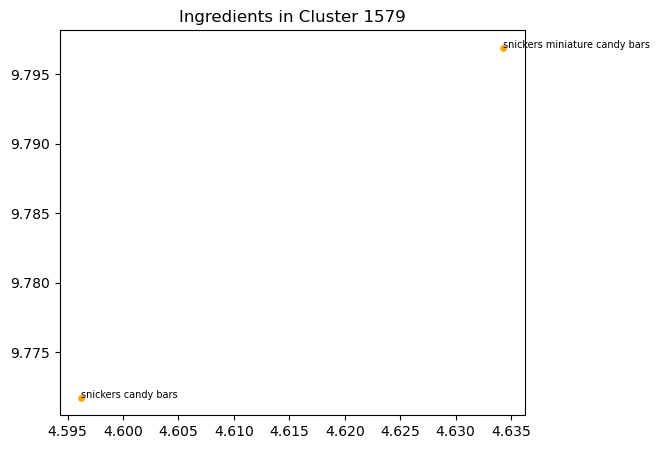

In [12]:
# Example of a specific cluster
cid = 1579
subset = mapping_df[mapping_df["cluster"] == cid]

plt.figure(figsize=(6,5))
plt.scatter(subset["x"], subset["y"], color="orange", s=15)
for _, row in subset.iterrows():
    plt.text(row["x"], row["y"], row["ingredient"], fontsize=7)
plt.title(f"Ingredients in Cluster {cid}")
plt.show()

### 🧾 STEP 8 - Creating and checking the final result

In [13]:
df["ingredients_clean"] = df["ingredients_y"].apply(
    lambda lst: sorted(set(mapping.get(x, x) for x in lst))
)

i = np.random.randint(len(df))
print("Before:", df.loc[i, "ingredients_y"])
print("After:", df.loc[i, "ingredients_clean"])

Before: ['vegetable oil', 'unsweetened applesauce', 'unsweetened cocoa powder', 'sugar', 'allpurpose flour', 'baking powder', 'baking soda', 'eggs', 'vanilla', 'nuts']
After: ['allpurpose flour', 'baking powder', 'baking soda', 'egg', 'nuts', 'sugar', 'unsweetened applesauce', 'unsweetened cocoa powder', 'vanilla', 'vegetable oil']


### 💾 STEP 9 - Saving the final cleaned DataFrame

In [16]:
df.head()

,name_x,nutrition,n_steps,ingredients_y,minutes,ingredients_reduced,ingredients_clean
0,arriba baked winter squash mexican style,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"[winter squash, mexican seasoning, mixed spice...",55,"[frozen squash, mexican seasoning, olive oil, ...","[butter, frozen squash, honey, mexican seasoni..."
1,a bit different breakfast pizza,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"[prepared pizza crust, sausage patty, eggs, mi...",30,"[prepared pizza, egg, sausage patty, milk, che...","[cheese, egg, milk, prepared pizza, salt peppe..."
2,all in the kitchen chili,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"[ground beef, yellow onions, diced tomatoes, t...",130,"[yellow onion, tomato soup, water, ground cumi...","[cheddar cheese, chili powder, diced tomato, g..."
3,alouette potatoes,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,"[spreadable cheese with garlic and herbs, new ...",45,"[soft cheese spread with herbs, red wine vineg...","[new potato, olive oil, parsley, pepper, red b..."
4,amish tomato ketchup for canning,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"[tomato juice, apple cider vinegar, sugar, sal...",190,"[cinnamon oil, sugar, salt, dry mustard, cider...","[cider vinegar, cinnamon oil, clove oil, dry m..."


In [18]:
# Drop useless columns for the final csv
df.drop(columns=['ingredients_y', 'ingredients_reduced'], inplace=True)

# Rename ingredients_reduced to a simpler name
df.rename(columns={"ingredients_clean": "ingredients"}, inplace=True)

df.head()

,name_x,nutrition,n_steps,minutes,ingredients
0,arriba baked winter squash mexican style,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,55,"[butter, frozen squash, honey, mexican seasoni..."
1,a bit different breakfast pizza,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,30,"[cheese, egg, milk, prepared pizza, salt peppe..."
2,all in the kitchen chili,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,130,"[cheddar cheese, chili powder, diced tomato, g..."
3,alouette potatoes,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,45,"[new potato, olive oil, parsley, pepper, red b..."
4,amish tomato ketchup for canning,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,190,"[cider vinegar, cinnamon oil, clove oil, dry m..."


#### Export a dictionary of the final cleaned ingredients

In [ ]:
# Extract all unique final ingredients
ingredient_dict = sorted({ing for lst in df["ingredients_clean"] for ing in lst})

dict_path = "data/clean_data/ingredient_dictionary.csv"
pd.DataFrame({"ingredient": ingredient_dict}).to_csv(dict_path, index=False)

print(f"✅ Dictionary exported with {len(ingredient_dict)} unique ingredients: {dict_path}")

#### Export the final cleaned DataFrame to a new CSV

In [ ]:
output_path = "data/clean_data/ingredients_reduced.csv"
df.to_csv(output_path, index=False)
print(f"✅ New CSV saved: {output_path}")

✅ New CSV saved: data/clean_data/ingredients_reduced.csv


### 🔍 STEP 10 - Qualitative inspection before / after cleaning

In [15]:
n_samples = 5

sample_indices = random.sample(range(len(df)), n_samples)

print("\n🔍 Qualitative check of cleaning:\n")
for i in sample_indices:
    before = df.loc[i, "ingredients_y"]
    after = df.loc[i, "ingredients_clean"]
    print(f"Recipe {i}")
    print("Before:", before)
    print("After:", after)
    print("-" * 80)


🔍 Qualitative check of cleaning:

Recipe 112432
Before: ['roma tomatoes', 'jalapeno peppers', 'habanero peppers', 'banana peppers', 'bell pepper', 'cilantro', 'garlic', 'onion', 'white sugar', 'brown sugar', 'salt fresh ground pepper', 'white vinegar', 'worcestershire sauce', 'tomato sauce', 'lemon juice', 'lime juice']
After: ['banana pepper', 'bell pepper', 'brown sugar', 'cilantro', 'fresh ground pepper', 'garlic', 'habanero pepper', 'jalapeno pepper', 'lemon juice', 'lime juice', 'onion', 'roma tomato', 'tomato sauce', 'white sugar', 'white vinegar', 'worcestershire sauce']
--------------------------------------------------------------------------------
Recipe 57113
Before: ['wide egg noodles', 'butter', 'cream of chicken soup', 'milk', 'cheese', 'salt', 'pepper', 'cooked chicken breasts', 'breadcrumbs']
After: ['breadcrumbs', 'butter', 'cheese', 'cooked chicken breast', 'cream of chicken soup', 'egg noodles', 'milk', 'pepper', 'salt']
---------------------------------------------